# QLSTM Testing
This document conducts basic test fits on time series curves. Later we also introduce noise to the equation.

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from q_lstm_tf import QLSTM
from quantum.util.dataset_creator import create_dataset
import tensorflow.experimental.numpy as np
from model_saver import ModelSaver
tf.keras.backend.set_floatx('float64')

import pennylane as qml

dtype_global = tf.float64




Using Quantum Device: <lightning.qubit device (wires=2) at 0x1a044570850>


Lets start by fitting a simple sinusoid:

In [2]:
X, y = create_dataset(tf.sin, sample_count=100, dtype=dtype_global, end=6*np.pi)
dataset = tf.data.Dataset.from_tensor_slices((X, y))

dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the data
dataset = dataset.batch(32)                 # Batch size of 32
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for performance

qubits = 2
dev = qml.device('default.qubit', wires=qubits)

### Plot Train data

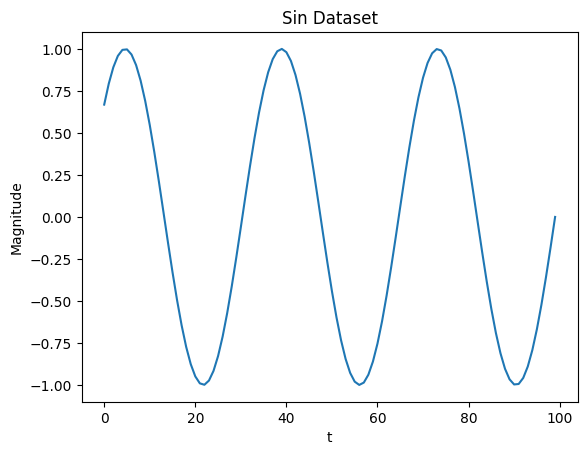

In [3]:
plt.plot(y)
plt.title("Sin Dataset")
plt.xlabel('t')
plt.ylabel('Magnitude')
plt.show()

### Create trainers for LSTM and QLSTM

In [4]:

model = tf.keras.Sequential([QLSTM(16, layers=2, wires=qubits, dtype=dtype_global, return_sequences=False, dev=dev), tf.keras.layers.Dense(1, dtype=dtype_global)])
optimizer = tf.keras.optimizers.Adam(learning_rate=.1, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='mse')
history_q = model.fit(dataset, validation_data=dataset,epochs=300,
                      callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), ModelSaver(f"./quantum/checkpoints/sin_qlstm/q{qubits}.model")]
                      )

Epoch 1/300
tf.Tensor(
[[-4.36734679e-04  3.97231572e-04 -1.37663856e-04  5.92781347e-04
  -6.01493321e-05 -1.58146641e-06]
 [ 6.50198290e-04  1.62094482e-04  5.42101086e-20 -5.65732071e-04
   1.83298041e-05  5.42101086e-20]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[-3.75532199e-03 -2.21665373e-03 -1.58106975e-03 -8.00120664e-04
  -4.78672697e-03 -1.37099557e-04]
 [-2.26923364e-04  1.09352069e-03  3.86247024e-19 -4.29976080e-03
   9.19030547e-04  6.77626358e-20]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[-2.76716257e-03 -9.34463228e-03 -3.70017437e-03  1.25031755e-02
  -1.81852880e-02 -2.40825012e-03]
 [-4.98258840e-03  1.25498168e-02  1.08420217e-19 -4.04624099e-03
  -6.43040187e-03 -4.33680869e-19]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[ 3.67814917e-03 -9.31981252e-04  1.46747875e-04 -4.21653748e-03
  -2.20549172e-03  7.93965514e-04]
 [ 6.81747765e-04 -3.18689819e-03  8.67785254e-19  2.72381441e-03
  -9.34924515e-04  1.41073337e-18]], shape=(2, 6), dtype=float64)
tf.Tensor(
[

{'loss': [0.540688642055257, 0.24248492956787446, 0.22945697907428605, 0.09202427829522992, 0.074009930510963, 0.0810880551280462, 0.05304886428486328, 0.028085551556268008, 0.010435326349426939, 0.002254917127947423, 0.0015143062620281687, 0.0016409647785040765, 0.0009441216618463457], 'val_loss': [0.3513476890209738, 0.1514825742328795, 0.09979694904091758, 0.09076947617610712, 0.1009451062665231, 0.06739720517798135, 0.025538513576915885, 0.007564171274705299, 0.0016840414339984384, 0.0018984829580889517, 0.0009443727690246957, 0.0009877699536777202, 0.001134997841080671]}


Text(0.5, 1.0, 'Sine loss of QLSTM with 2')

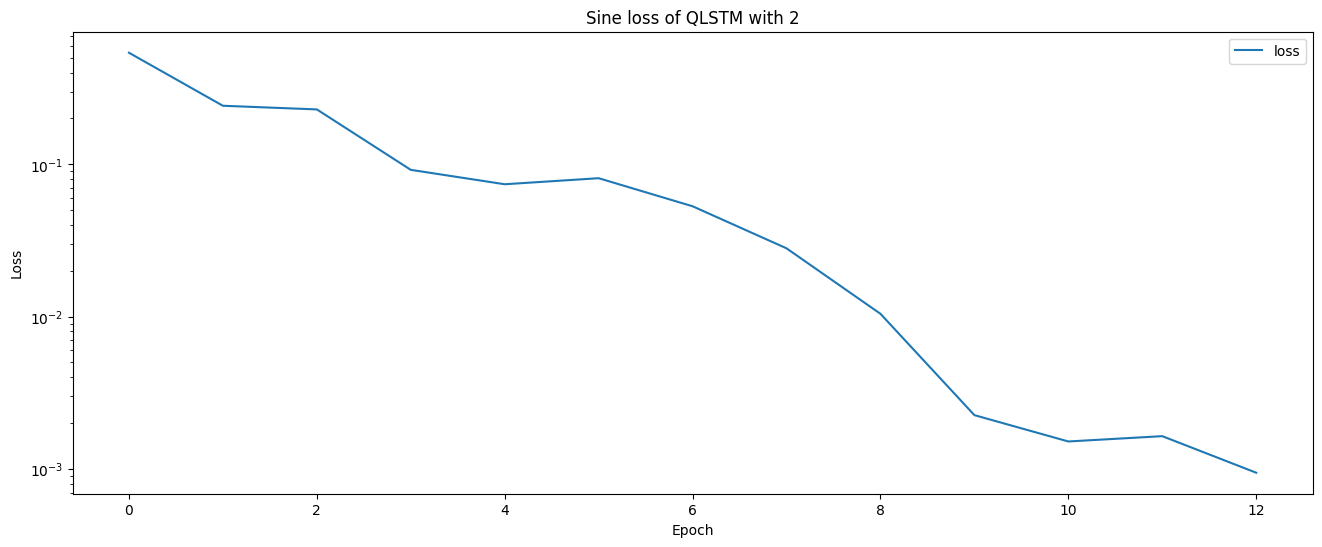

In [5]:
metrics = history_q.history
print(metrics)
plt.figure(figsize=(16,6))
plt.plot(history_q.epoch, metrics['loss'])
plt.legend(['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(f"Sine loss of QLSTM with {qubits}")

In [6]:
model = tf.keras.Sequential([tf.keras.layers.LSTM(128, dtype=dtype_global, return_sequences=False)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(dataset, epochs=300, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

Epoch 1/300
Tensor("IdentityN:0", shape=(1, 512), dtype=float64)
Tensor("IdentityN:1", shape=(128, 512), dtype=float64)
Tensor("IdentityN:2", shape=(512,), dtype=float64)
Tensor("IdentityN:0", shape=(1, 512), dtype=float64)
Tensor("IdentityN:1", shape=(128, 512), dtype=float64)
Tensor("IdentityN:2", shape=(512,), dtype=float64)
4/4 [==============================] - 2s 4ms/step - loss: 0.5125
Epoch 2/300
4/4 [==============================] - 0s 4ms/step - loss: 0.5042
Epoch 3/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4955
Epoch 4/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4870
Epoch 5/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4781
Epoch 6/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4681
Epoch 7/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4570
Epoch 8/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4442
Epoch 9/300
4/4 [==============================] - 0s 4ms/

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
Total params: 66560 (520.00 KB)
Trainable params: 66560 (520.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Text(0.5, 1.0, 'Sine loss')

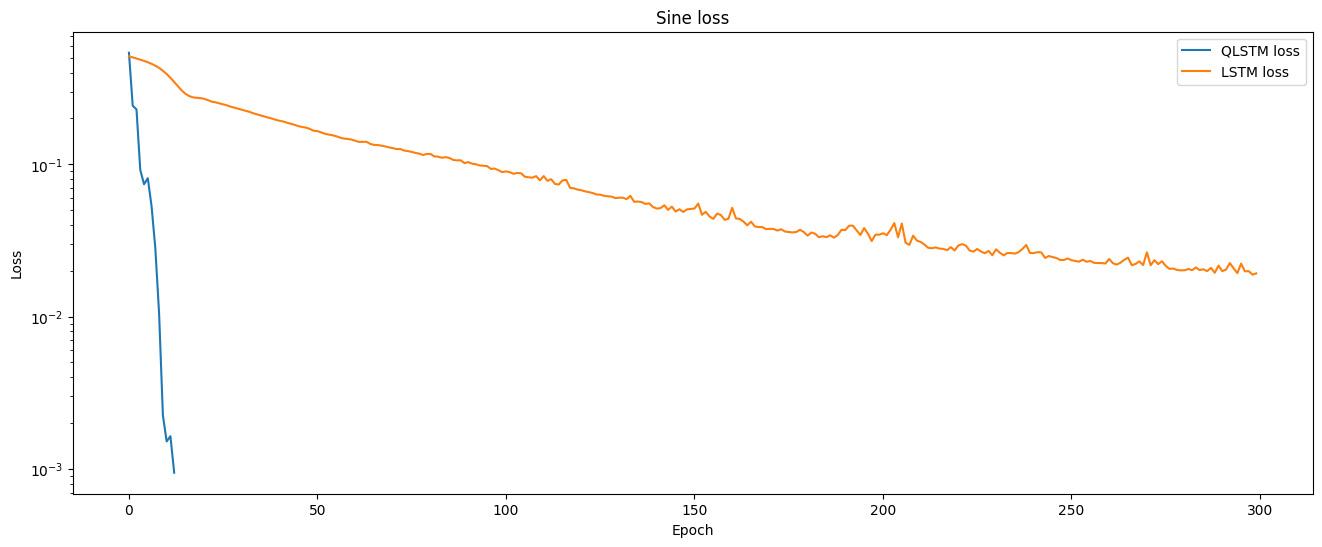

In [8]:
metrics = history.history
q_metrics = history_q.history
plt.figure(figsize=(16,6))
plt.plot(history_q.epoch, q_metrics['loss'])
plt.plot(history.epoch, metrics['loss'])

plt.legend(['QLSTM loss', 'LSTM loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(f"Sine loss")

In [9]:
X, y = create_dataset(lambda x: tf.exp(-0.25*x) * tf.sin(4.0*x), sample_count=100, dtype=dtype_global)

dataset_basel = tf.data.Dataset.from_tensor_slices((X, y))

dataset_basel = dataset_basel.shuffle(buffer_size=1000)  # Shuffle the data
dataset_basel = dataset_basel.batch(100)                 # Batch size of 32
dataset_basel = dataset_basel.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for performance

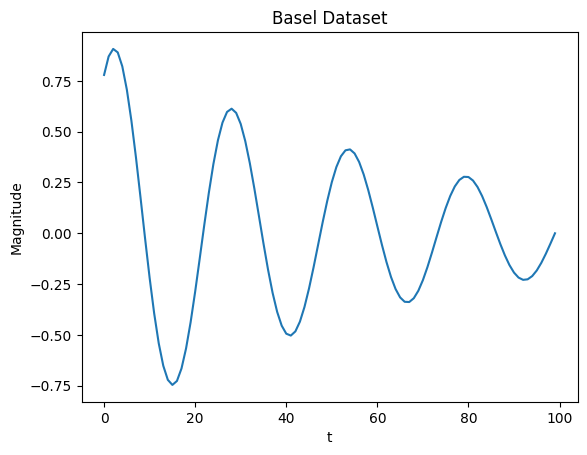

In [10]:
plt.plot(y)
plt.title("Basel Dataset")
plt.xlabel('t')
plt.ylabel('Magnitude')
plt.show()

In [11]:
model = tf.keras.Sequential([QLSTM(1, layers=2, wires=qubits, dtype=dtype_global, return_sequences=False, dev=dev)])
optimizer = tf.keras.optimizers.Adam(learning_rate=.1, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='mse')

history_q = model.fit(dataset_basel, epochs=300, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)
print(model.summary())


Epoch 1/300
tf.Tensor(
[[ 8.85799096e-03  1.00691978e-02 -3.00238964e-03  4.07888281e-03
  -4.24712707e-06  3.05910997e-03]
 [-2.45508280e-03  5.56226879e-03  4.65868121e-21  1.27285047e-02
   9.72842059e-03 -2.01170325e-21]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[-5.36289492e-03  1.55605023e-03  1.66668117e-03  2.39178424e-03
  -7.49278837e-03 -4.06822940e-04]
 [ 4.87528811e-03 -8.08919992e-04  4.06575815e-20 -4.37401109e-03
  -4.33510496e-04 -3.38813179e-21]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[-4.52675743e-03 -1.98999706e-02 -1.34942233e-02  1.71440468e-02
  -2.22673574e-03 -1.09347867e-02]
 [ 2.94680056e-02 -1.82964085e-02  2.16840434e-19  4.02717893e-03
  -1.30357689e-02 -1.62630326e-19]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[ 2.32427290e-02  3.10058757e-03 -8.01522851e-03  4.41414391e-03
  -4.50736826e-03  8.74807733e-04]
 [-9.25677488e-04  6.01556147e-03  4.33680869e-19  1.99401922e-02
   3.39352689e-03  1.12485975e-18]], shape=(2, 6), dtype=float64)
tf.Tensor(
[

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qlstm_1 (QLSTM)             (None, 1)                 83        
                                                                 
Total params: 83 (664.00 Byte)
Trainable params: 83 (664.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model = tf.keras.Sequential([tf.keras.layers.LSTM(128, dtype=dtype_global, return_sequences=False)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(dataset_basel, epochs=300, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

Epoch 1/300
Tensor("IdentityN:0", shape=(1, 512), dtype=float64)
Tensor("IdentityN:1", shape=(128, 512), dtype=float64)
Tensor("IdentityN:2", shape=(512,), dtype=float64)
Tensor("IdentityN:0", shape=(1, 512), dtype=float64)
Tensor("IdentityN:1", shape=(128, 512), dtype=float64)
Tensor("IdentityN:2", shape=(512,), dtype=float64)
1/1 [==============================] - 2s 2s/step - loss: 0.1502
Epoch 2/300
1/1 [==============================] - 0s 10ms/step - loss: 0.1496
Epoch 3/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1490
Epoch 4/300
1/1 [==============================] - 0s 10ms/step - loss: 0.1485
Epoch 5/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1479
Epoch 6/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1473
Epoch 7/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1467
Epoch 8/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1461
Epoch 9/300
1/1 [==============================] - 0s 10m

Text(0.5, 1.0, 'Sine loss')

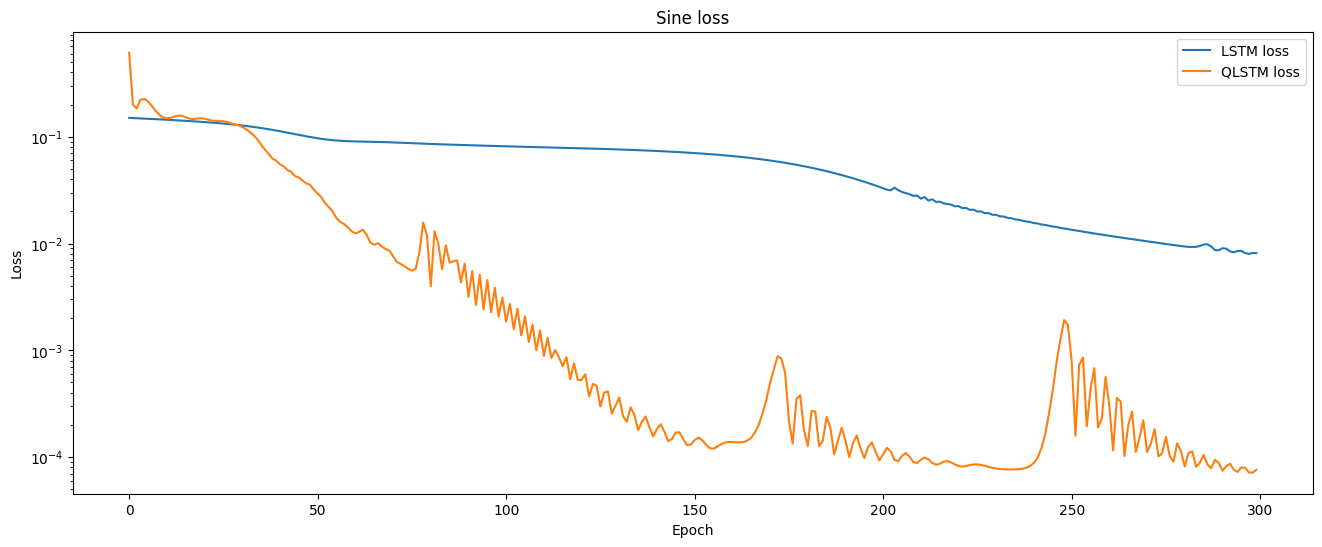

In [14]:
metrics = history.history
q_metrics = history_q.history
plt.figure(figsize=(16,6))
plt.plot(history_q.epoch, metrics['loss'], q_metrics['loss'])

plt.legend(['LSTM loss', 'QLSTM loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(f"Sine loss")

In [15]:
X, y = create_dataset(tf.sin, sample_count=100, dtype=dtype_global, end=12*np.pi)
X = tf.reshape(tf.stack([X, X], axis=2), (100, 4, 2))

dataset = tf.data.Dataset.from_tensor_slices((X, y))

dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the data
dataset = dataset.batch(32)                 # Batch size of 32
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for performance

qubits = 2
dev = qml.device('default.qubit', wires=qubits)

In [17]:

model = tf.keras.Sequential([QLSTM(2, layers=2, wires=qubits, dtype=dtype_global, return_sequences=False, dev=dev)])
optimizer = tf.keras.optimizers.Adam(learning_rate=.05, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='mse')
history_q = model.fit(dataset, validation_data=dataset,epochs=300,
                      callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), ModelSaver(f"./quantum/checkpoints/sin_qlstm/q{qubits}.model")]
                      )

Epoch 1/300
tf.Tensor(
[[ 1.60614149e-03 -1.53783558e-03  1.70446620e-03  4.51106847e-04
  -7.58403997e-04  4.44698207e-04]
 [-2.11322636e-04  2.38174580e-03 -5.92923063e-20  6.24197234e-04
   8.25806924e-04 -4.23516474e-21]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[ 1.84713470e-04 -1.58241717e-03 -7.75497862e-04 -1.18560331e-03
   1.73963213e-03 -4.46461799e-04]
 [ 1.25570204e-03  7.63280269e-04  1.55854062e-19  1.12652781e-03
   5.79108429e-05  3.38813179e-20]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[ 1.48544349e-03 -9.05214941e-03  1.31500034e-03 -1.72160266e-03
   1.46011256e-02  4.95346101e-03]
 [ 2.37198447e-02 -1.18545278e-02 -5.58194712e-19 -2.34410411e-03
  -2.61226423e-04 -6.36968776e-19]], shape=(2, 6), dtype=float64)
tf.Tensor(
[[ 1.72570237e-03  2.49922404e-04  1.40319262e-03  1.06986191e-03
   2.71403934e-03  1.36273797e-03]
 [ 1.86766234e-03 -1.93974122e-03 -5.50108195e-20  1.16962754e-03
  -3.69069874e-04 -3.38813179e-20]], shape=(2, 6), dtype=float64)
tf.Tensor(
[

{'loss': [0.6128315417155401, 0.32010325974217474, 0.19755313816734943, 0.1598781506918972, 0.09100480367662848, 0.06773440650160532, 0.04557066667760799, 0.04409866174467707, 0.03462855660079588, 0.04664323313019841, 0.03650383046607682, 0.02716992278462163, 0.028071232047858097, 0.021950037148346375, 0.017756020838932633, 0.02189235756476136, 0.022516974134403584, 0.022736078132509982], 'val_loss': [0.34046868698035865, 0.22225205289848618, 0.17532616955998845, 0.1077224740353468, 0.07170530056154739, 0.04764428629885068, 0.04455404451068494, 0.0369315561751275, 0.06700734714475519, 0.03547736576179833, 0.02830046992286062, 0.028567131129014215, 0.022086063430118336, 0.01768297300576677, 0.016258612388432698, 0.013441483222646078, 0.020715333353510862, 0.03814407222809479]}


Text(0.5, 1.0, 'Sine loss of QLSTM with 2')

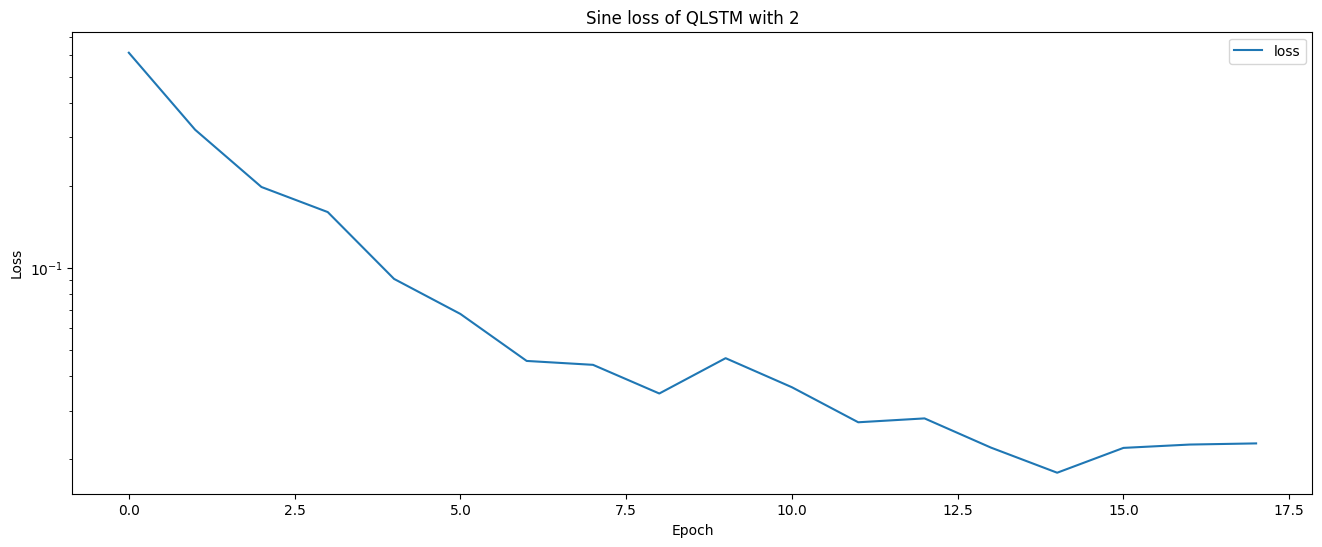

In [ ]:
metrics = history_q.history
print(metrics)
plt.figure(figsize=(16,6))
plt.plot(history_q.epoch, metrics['loss'])
plt.legend(['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(f"Sine loss of QLSTM with {qubits}")

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.LSTM(128, dtype=dtype_global, return_sequences=False)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(dataset, epochs=300, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

Epoch 1/300
Tensor("IdentityN:0", shape=(2, 512), dtype=float64)
Tensor("IdentityN:1", shape=(128, 512), dtype=float64)
Tensor("IdentityN:2", shape=(512,), dtype=float64)
Tensor("IdentityN:0", shape=(2, 512), dtype=float64)
Tensor("IdentityN:1", shape=(128, 512), dtype=float64)
Tensor("IdentityN:2", shape=(512,), dtype=float64)
4/4 [==============================] - 1s 3ms/step - loss: 0.5015
Epoch 2/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4949
Epoch 3/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4886
Epoch 4/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4819
Epoch 5/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4753
Epoch 6/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4687
Epoch 7/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4617
Epoch 8/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4549
Epoch 9/300
4/4 [==============================] - 0s 3ms/